In [1]:
import os
import sys

import sys
sys.path.append('..')

import tensorflow as tf
import pandas as pd
import matplotlib.pylab as plt
import bokeh.io
import bokeh.mpl
import bokeh.plotting
import numpy as np
import seaborn as sns

from scipy.stats import itemfreq
from datetime import datetime
from glob import glob

from libs.utilities import accuracy, predict
from libs.architecture import inference
from pipeline import inputs
from config import SVHNParams

%load_ext autoreload
%autoreload 1
%matplotlib inline
%config InlineBackend.figure_formats = {'jpg', 'retina'}

In [2]:
# Plotting parameters
rc = {'lines.linewidth': 2, 
      'axes.labelsize': 10,
      'figure.figsize': (4, 4),
      'axes.titlesize': 10, 
      'axes.facecolor': 'DFDFE5',
      'axes.linecolor': 'white'}

sns.set_context('notebook', rc=rc)
sns.set_style('whitegrid', rc=rc)
bokeh.io.output_notebook()

Loading BokehJS ...

# Best Model

In [3]:
best_checkpoint = '/Users/kvn219/PycharmProjects/multi-svhn/checkpoints/GrayScale/GrayScale-62000'

# Set-up Parameters

In [4]:
params = SVHNParams()
params.name = "GrayScale"
params.mode = "test"
params.channel = 1
params.checkpoint_dir = '/Users/kvn219/PycharmProjects/multi-svhn/checkpoints/GrayScale/'
params.num_epochs = 1
params.batch_size =  params.num_test
params.is_training = False
params.verbose =  True
params.record_name = '/test.tfrecords'
params.records_path = '/Users/kvn219/PycharmProjects/multi-svhn/Users/kvn219/PycharmProjects/multi-svhn/records/test/test.tfrecords'
params.records_dir = '/Users/kvn219/PycharmProjects/multi-svhn/records/test'
params.gray_scale = True
params.random_crop = False

# Double check parameters

In [5]:
vars(params)

{'batch_size': 13068,
 'channel': 1,
 'checkpoint_dir': '/Users/kvn219/PycharmProjects/multi-svhn/checkpoints/GrayScale/',
 'checkpoint_dir_path': '/Users/kvn219/PycharmProjects/multi-svhn/notebooks/checkpoints/kvn',
 'data_dir': '/Users/kvn219/PycharmProjects/multi-svhn/notebooks/data/',
 'data_url': 'http://ufldl.stanford.edu/housenumbers/',
 'dir_path': '/Users/kvn219/PycharmProjects/multi-svhn/notebooks',
 'extra_gz': 'extra.tar.gz',
 'gray_scale': True,
 'is_training': False,
 'lrate': 0.0001,
 'mode': 'test',
 'name': 'GrayScale',
 'num_epochs': 1,
 'num_test': 13068,
 'num_train': 223972,
 'num_valid': 11782,
 'pixels': 4096,
 'random_crop': False,
 'record_name': '/test.tfrecords',
 'records_dir': '/Users/kvn219/PycharmProjects/multi-svhn/records/test',
 'records_path': '/Users/kvn219/PycharmProjects/multi-svhn/Users/kvn219/PycharmProjects/multi-svhn/records/test/test.tfrecords',
 'results_dir': '/Users/kvn219/PycharmProjects/multi-svhn/notebooks/results/kvn/',
 'results_path':

# Run Model on Test Set

In [6]:
with tf.Graph().as_default() as graph:

    # Inputs
    images, labels = inputs(params)

    # Model
    logits = inference(params, images)

    # Predictions
    predictions = predict(logits)

    # Timeoutt
    timeout = tf.ConfigProto(operation_timeout_in_ms=60000)

    ## Initializer
    init = tf.group(tf.global_variables_initializer(), tf.local_variables_initializer())

    with tf.Session(graph=graph, config=timeout) as sess:

        # Start  session
        sess.run(init)

        # Saver
        saver = tf.train.Saver()

        # Coordinator
        coord = tf.train.Coordinator()

        # Treads
        threads = tf.train.start_queue_runners(sess=sess, coord=coord)

        # Restore model
        print("Restoring....", best_checkpoint)
        saver.restore(sess, best_checkpoint)

        start_time = datetime.now()

        try:
            scores = []

            while not coord.should_stop():
                y_pred, X, y = sess.run([predictions, images, labels])

        except tf.errors.OutOfRangeError:
            print('Stopping evaluation at {:4d} epochs.'.format(params.num_epochs))

        finally:
            coord.request_stop()
        coord.join(threads)
        sess.close()
        print("Total time to run: {}".format(datetime.now() - start_time))

ConvNet/C1
Input: [13068, 32, 32, 1]
Filter: [3, 3]
Stride: 1
Hidden units: [1, 16]
Output: [13068, 32, 32, 16]

ConvNet/C2
Input: [13068, 32, 32, 16]
Filter: [3, 3]
Stride: 1
Hidden units: [16, 32]
Output: [13068, 32, 32, 32]

ConvNet/C3
Input: [13068, 32, 32, 32]
Filter: [5, 5]
Stride: 3
Hidden units: [32, 64]
Output: [13068, 11, 11, 64]

ConvNet/C4
Input: [13068, 11, 11, 64]
Filter: [5, 5]
Stride: 3
Hidden units: [64, 256]
Output: [13068, 4, 4, 256]

Restoring.... /Users/kvn219/PycharmProjects/multi-svhn/checkpoints/GrayScale/GrayScale-62000
Stopping evaluation at    1 epochs.
Total time to run: 0:00:22.834584


# Metric

In [7]:
correct_digits = 45
num_images = 10
num_of_digits_in_an_image = 5

(correct_digits/num_images)/num_of_digits_in_an_image

0.9

In [8]:
def digit_accuracy(predictions, labels):
    return (100.0 * np.sum(np.argmax(predictions, 2).T == labels[:, 1:]) / predictions.shape[1] / predictions.shape[0])

In [9]:
digit_accuracy(y_pred, y)

95.009182736455472

# Plotting Helper

In [10]:
def convert_to_label(arr):
    label = [digit for digit in arr if digit != 10]
    return ''.join(str(digit) for digit in label)

# Set-up data for plotting

In [11]:
error_mat = np.argmax(y_pred, 2).T == y[:, 1:]
pred_mat = np.argmax(y_pred, 2).T
truth_mat = y[:, 1:]
error_index = np.where(np.sum(error_mat, axis=1) !=5)[0]

# Randomly Plot Predictions

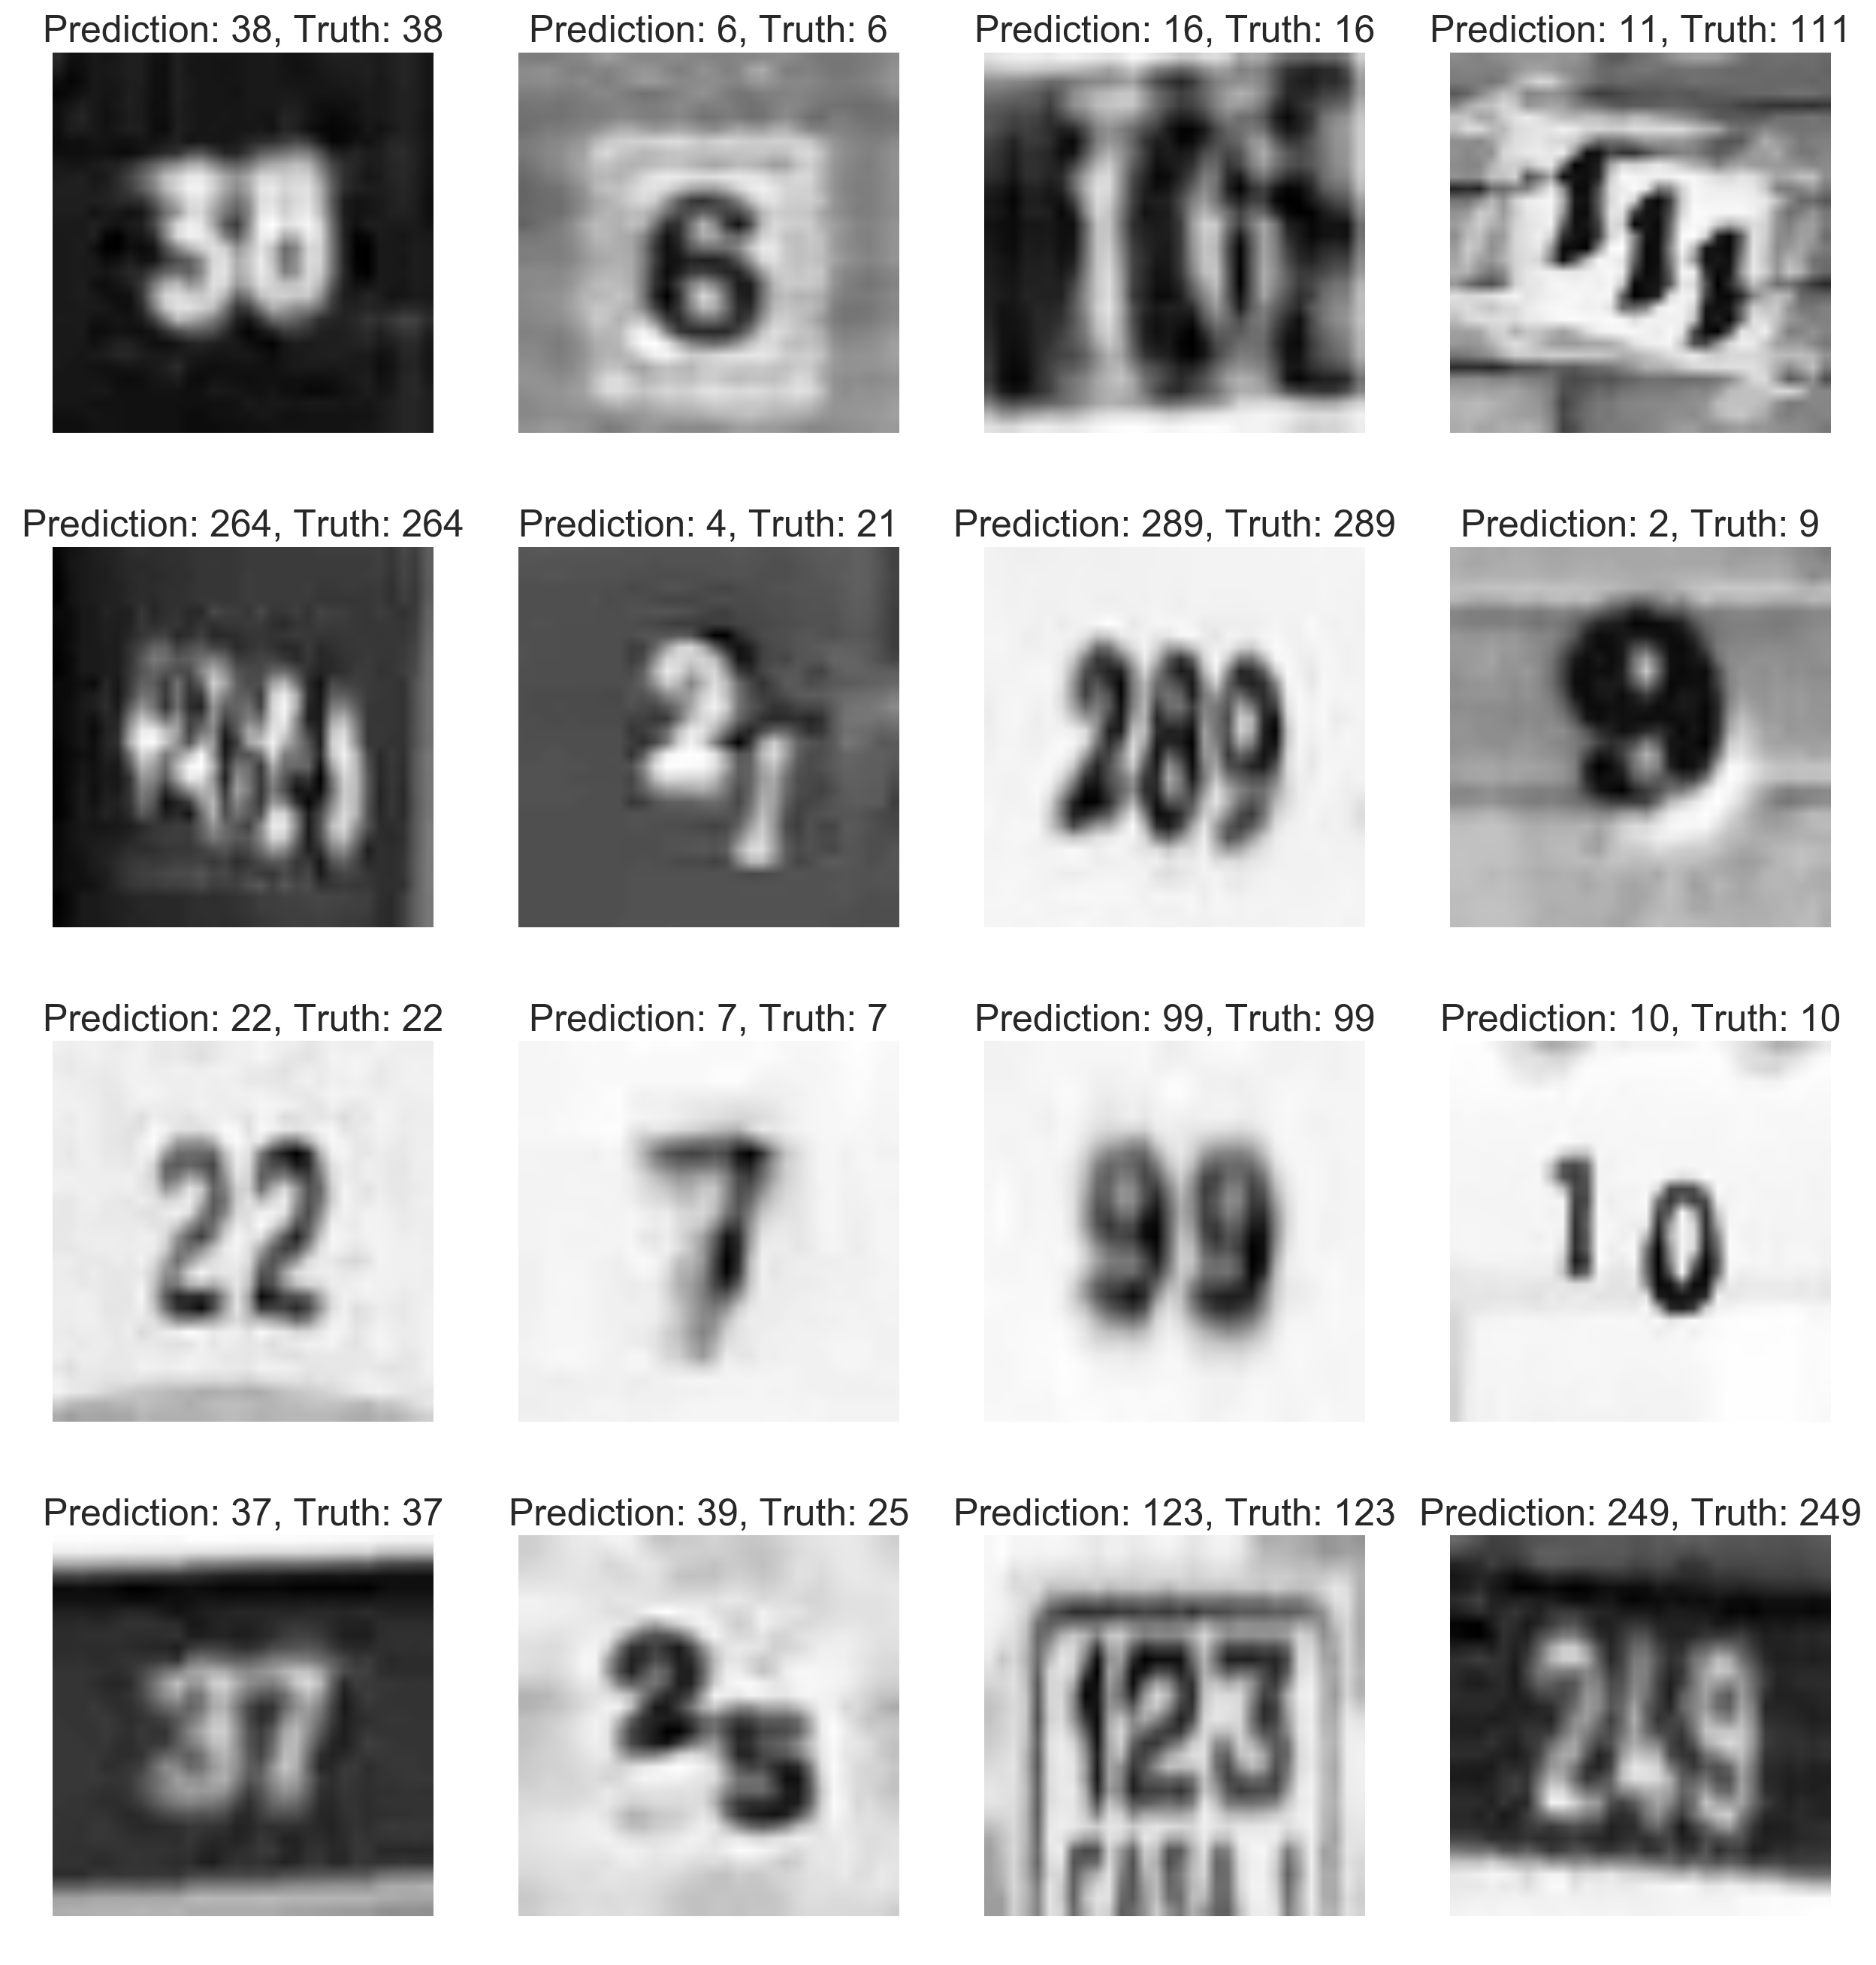

In [13]:
# set seed to reproduce plots
np.random.seed = 99

ith = 0
plt.rcParams['figure.figsize'] = (16.0, 16.0)
plt.subplots_adjust(wspace=0, hspace=.3)
for index in np.random.randint(1, 11000, size=16):
    plt.subplot(4, 4, ith+1)
    pred = convert_to_label(pred_mat[index])
    truth = convert_to_label(truth_mat[index])
    plt.title("Prediction: {}, Truth: {}".format(pred, truth), {'fontsize': 18})
    plt.imshow(X[index][...,0])
    plt.axis('off')
    ith += 1

# Plot Errors

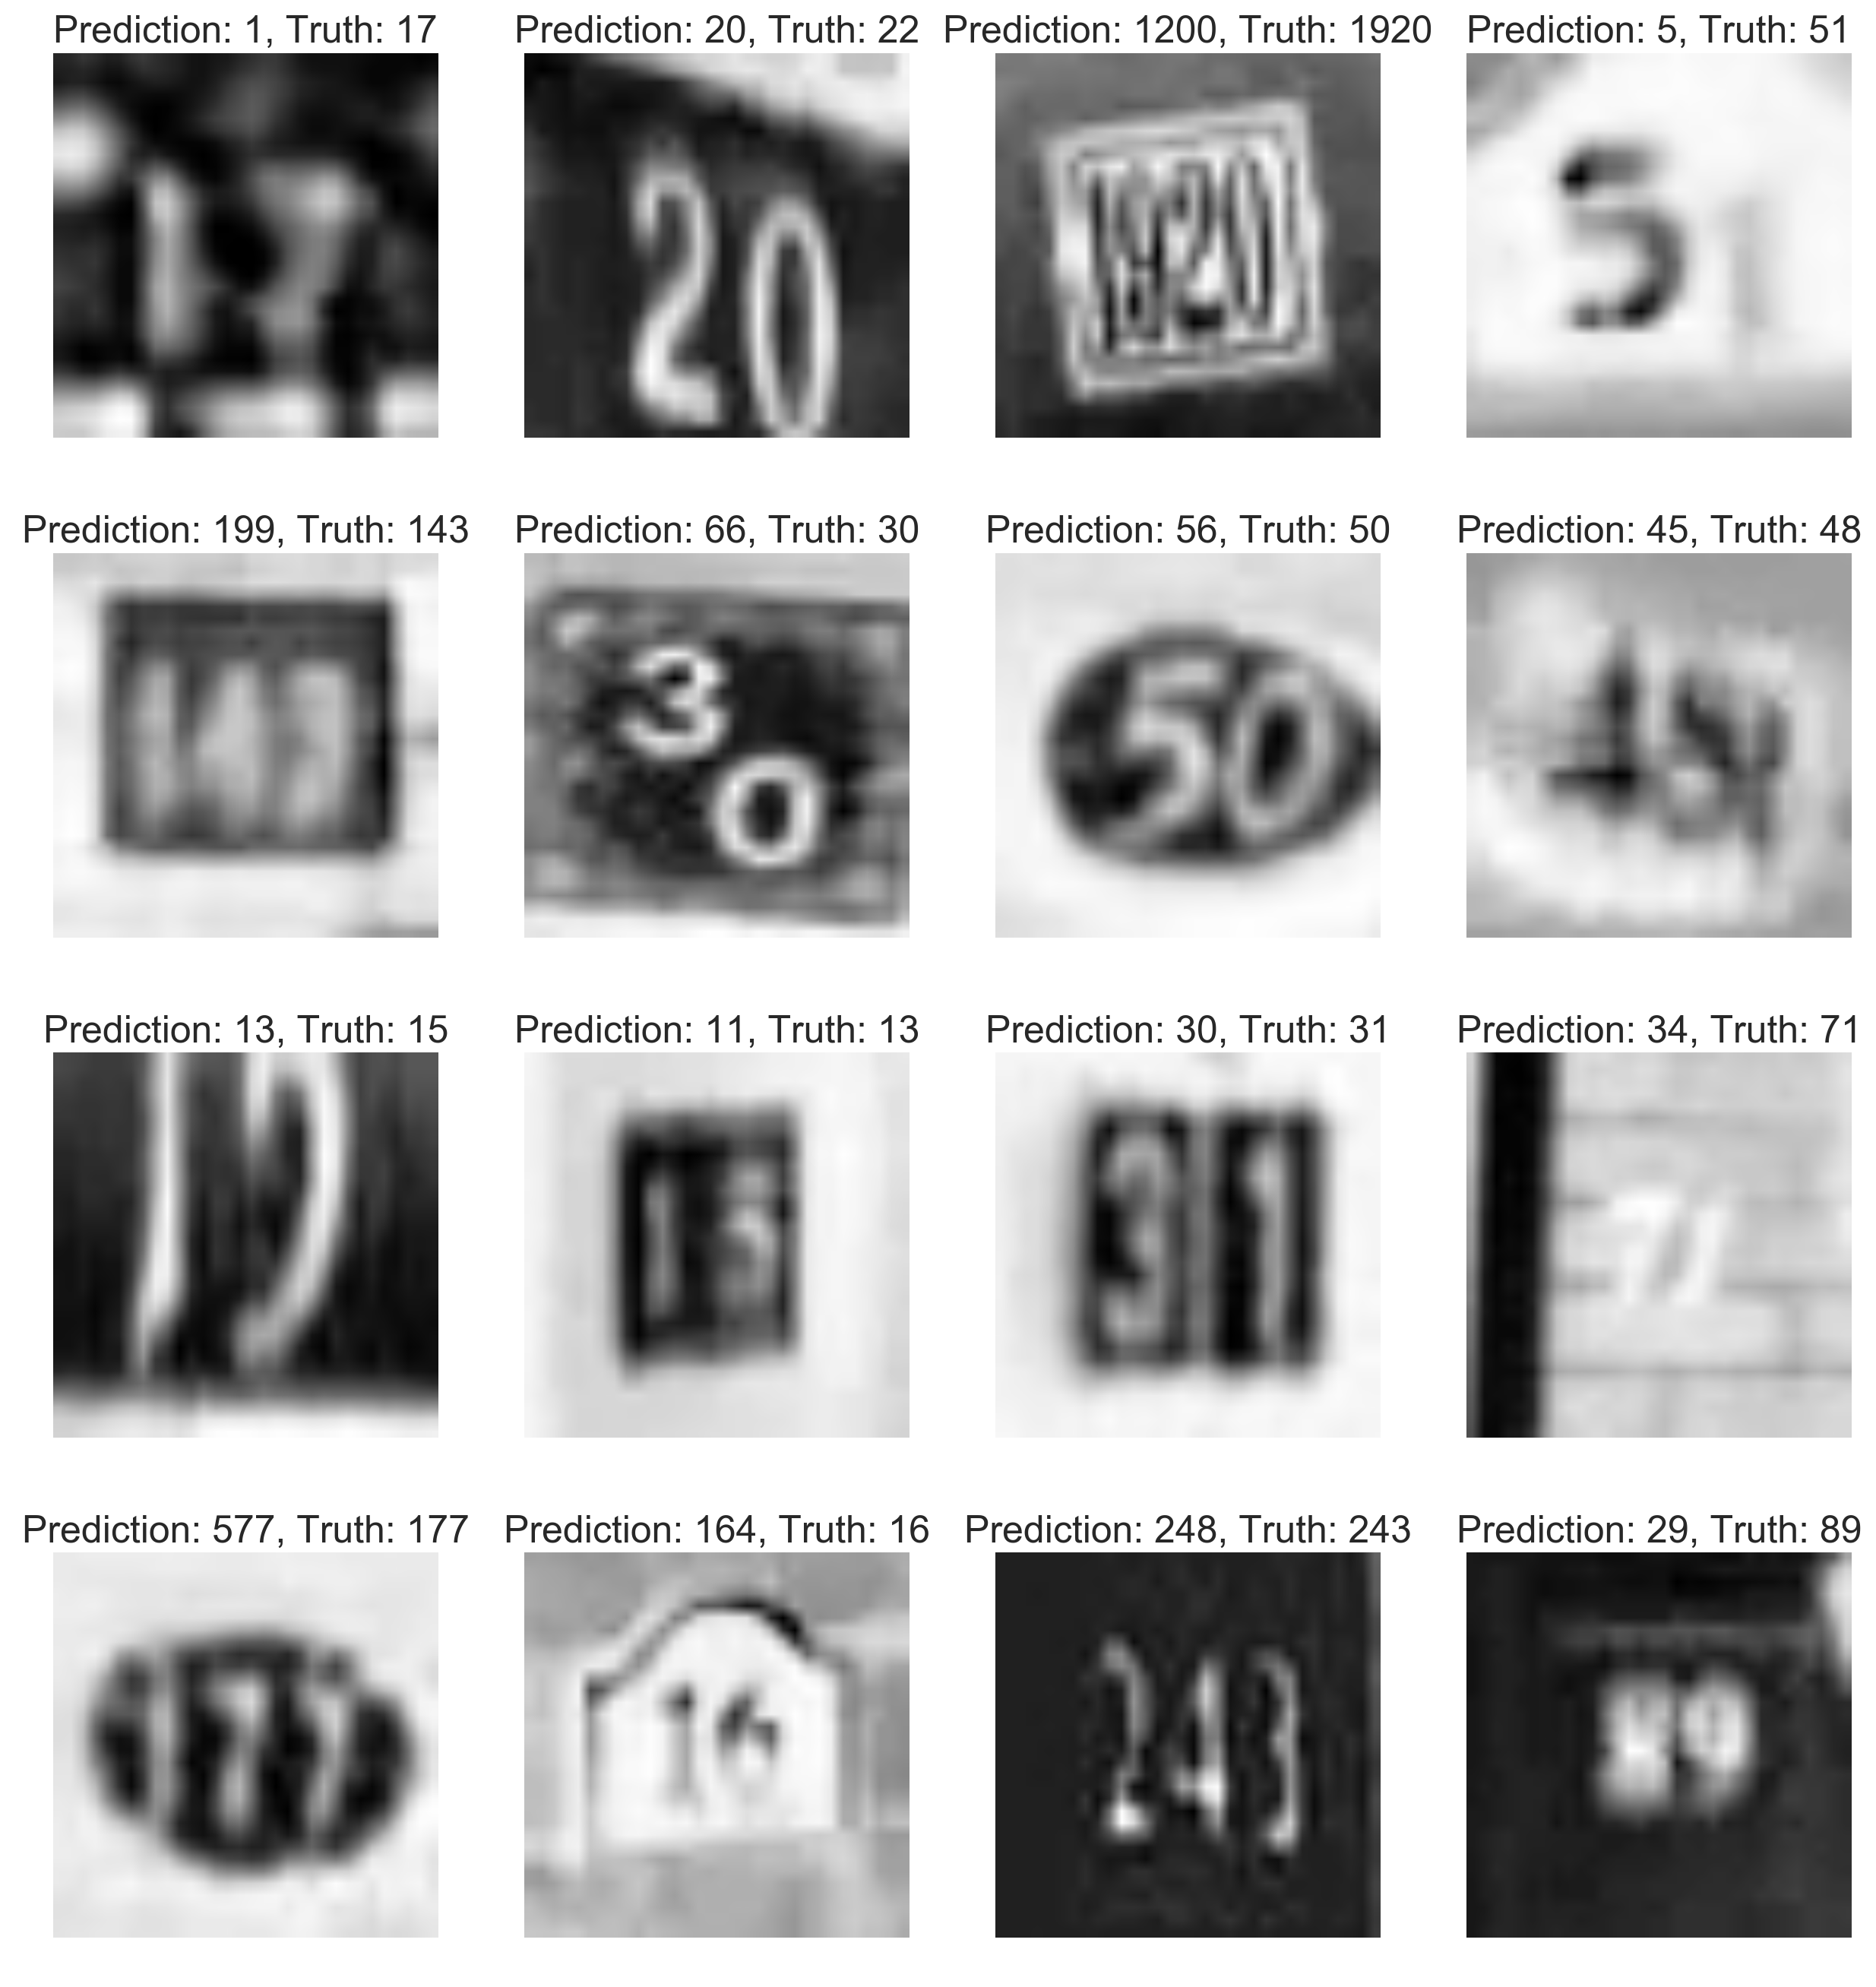

In [14]:
ith = 0
plt.rcParams['figure.figsize'] = (16.0, 16.0)
plt.subplots_adjust(wspace=0, hspace=.3)
for index in np.random.choice(error_index, size=16):
    plt.subplot(4, 4, ith+1)
    pred = convert_to_label(pred_mat[index])
    truth = convert_to_label(truth_mat[index])
    plt.title("Prediction: {}, Truth: {}".format(pred, truth), {'fontsize': 18})
    plt.imshow(X[index][...,0])
    plt.axis('off')
    ith += 1